# Starbucks Capstone Challenge

### Introduction

The Starbucks Capstone Project is a key component of the Udacity Data Science Nanodegree program, providing students with a hands-on opportunity to apply their skills and knowledge gained throughout the program to a real-world business challenge. This project is developed in collaboration with Starbucks, a global coffeehouse chain where the author enjoys sipping their matcha latte everyday, making it an engaging and relevant experience for aspiring data scientists such as the author.

Starbucks, a renowned brand in the food and beverage industry, has provided simulated data that mimics customer behavior on their rewards mobile app. The dataset spans diverse aspects of customer interactions, including offers received, viewed, and completed, as well as transaction details. The primary objective of the capstone project is to analyze this dataset and develop a machine learning model that predicts whether a customer will respond to a particular offer.

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You"ll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You"ll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You"ll also want to take into account that some demographic groups will make purchases even if they don"t receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn"t want to send a buy 10 dollars get 2 dollars off offer. You"ll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don"t need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain "O" for other rather than M or F)
* id (str) - customer id
* income (float) - customer"s income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# I. Data Acquisition

In this session, we read the 3 JSON files. For each file, extract DataFrame, and then have a brief look at data distribution.

In [2]:
# Read JSON file - Portfolio
portfolio = pd.read_json(
    "data/portfolio.json", 
    orient = "records", 
    lines = True
)
print("Portfolio info:")
print(portfolio.info())

print("\nPortfolio data distribution:")
print(portfolio.describe())

portfolio.head(10)

Portfolio info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None

Portfolio data distribution:
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# Read JSON file - Profile
profile = pd.read_json(
    "data/profile.json", 
    orient = "records", 
    lines = True
)
print("Profile info:")
print(profile.info())

print("\nProfile data distribution:")
print(profile.describe())

profile.head(20)

Profile info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None

Profile data distribution:
                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.0

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [4]:
# Read JSON file - Transcript
transcript = pd.read_json(
    "data/transcript.json", 
    orient = "records", 
    lines = True
)
print("Transcript info:")
print(transcript.info())

print("\nTranscript data distribution:")
print(transcript.describe())
transcript.head(20)

Transcript info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None

Transcript data distribution:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


# II. Data overview

## 1. Examine missing values (NaN)

From the above session, we can see that among 3 data sources, only `Profile` has null data in 2 out of 5 columns, which are:

- `gender`
- `income`

Then, we will try to have a deeper look at them in the next cell.

In [5]:
missing_profiles = profile[
    profile.isna().any(axis = 1)
]

print(f"Number of profiles either missing gender or income: {len(missing_profiles)}")
print(f"Percentage of NaN presence: {len(missing_profiles) / len(profile) * 100 :.3f} %")
print(f"Their data distribution:")
print(missing_profiles.describe())
missing_profiles.sample(10)

Number of profiles either missing gender or income: 2175
Percentage of NaN presence: 12.794 %
Their data distribution:
          age  became_member_on  income
count  2175.0      2.175000e+03     0.0
mean    118.0      2.016804e+07     NaN
std       0.0      1.009105e+04     NaN
min     118.0      2.013080e+07     NaN
25%     118.0      2.016070e+07     NaN
50%     118.0      2.017073e+07     NaN
75%     118.0      2.017123e+07     NaN
max     118.0      2.018073e+07     NaN


,gender,age,id,became_member_on,income
13993,None,118,27389f66304d483ba97a6afe011c702e,20160220,NaN
11278,None,118,5709166b8a4f46d0bc32db8b85e2d6fb,20160527,NaN
13442,None,118,3db080837a5f4137aeb5cab01f739866,20170329,NaN
16591,None,118,28476358ecb3414eb56e35ca6842bdb0,20180404,NaN
10262,None,118,8bafff02fd574a7d8abe2d548a1b01a0,20170806,NaN
6463,None,118,fcdc2cfe8e1e4ef184bada6c84e0d0b9,20180702,NaN
3355,None,118,8614aba093c549c9a9d38e212588763b,20180116,NaN
3874,None,118,c2dedd3d38044d9492060c4f4952ad5f,20141204,NaN
2779,None,118,d531d1b3ea68440889634a0239c20878,20180715,NaN
3594,None,118,bc05b86875da4bcb91338e2bde229a75,20170831,NaN


From the data distribution above, we can see these records are totally nonsense, with the same very high age of 118, and different membership starting dates, thus we can conclude all of them are indeed data errors.

They take 12.8% of the data, although not very small, but still an acceptable amount to drop.

Thus, we drop them.

In [6]:
print(f"Profile record number before dropping: {len(profile)}")
profile = profile.dropna()
print(f"Profile record number after dropping: {len(profile)}")

Profile record number before dropping: 17000
Profile record number after dropping: 14825


## 2. Deeper into data distribution

After NaNs are dealt with, we examine the data distribution and composition of these 3 tables.

Profile histograms
Portfolio histograms
Transcript histograms


array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

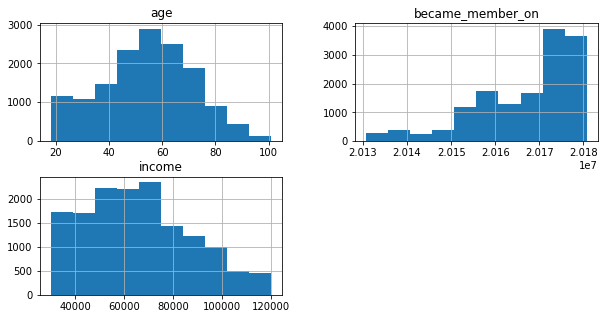

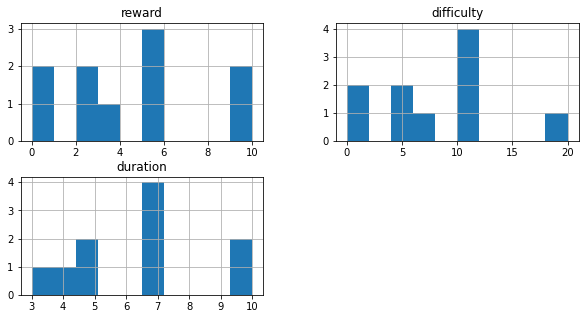

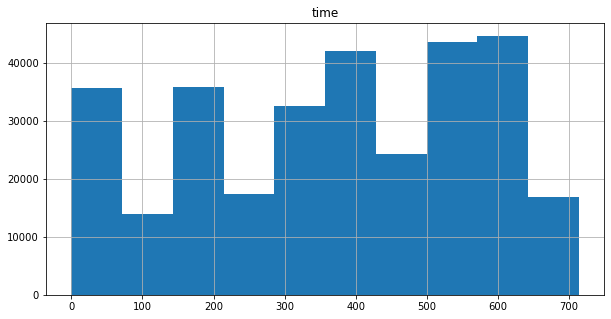

In [7]:
# Histogram of the numeric columns
print("Profile histograms")
profile.hist(figsize = (10, 5))

print("Portfolio histograms")
portfolio.hist(figsize = (10, 5))

print("Transcript histograms")
transcript.hist(figsize = (10, 5))

From this, we can acquire several initial understandings:

### a. Profile

- Age ranges from 18 to 102, creating a Gaussian-like distribution. This means we can try to split them into multiple age groups, like this:
    + Young adults: 18 - 29
    + Adults: 30 - 39
    + Middle-aged: 40 - 49
    + Past middle-aged: 50 - 59. This is the age range with highest popularity, indicating a high level of cofee consumption around this age.
    + Those levels of 60 - 69, 70 - 79, 80 - 89, 90 - 102 or so.

- Membership starting dates ranging from 2013 to 2018, with most of memberships being created recently.

- Income shows a lot of people with low or average income going to Starbucks. People with higher incomes, especially those six-figure guys seem to not really enjoying Starbucks coffee, which is explanable since they might be sipping red wine instead. Similar to age, income can be split into ranges too.

### b. Portfolio

- Rewards ranging from 0 to 10, with a majority at 5-6.
- Difficulties ranging from 0 to 20, with a majority at 10-12.
- Durations are either 3-5, around 7 or around 10, with 7 as the mode.

### c. Transcript

- Time ranging from 0 to 700, with no particular behaviors.

We also have several troublesome columns:

- Profile
    + `became_member_on` should be DateTime. But on second thought, since this is the ONLY DateTime column in our whole datasets, and we do not have any other reference timestamp, so this column is practically useless and can be dropped.
    + `gender` should be somewhat categorical one-hot encoded.

- Portfolio
    + `channels` should be categorical one-hot encoded.
    + `offer_type` should be one-hot.

- Transcript
    + `event` : one-hot.
    + `value` : extract the `offer_id` inside and turn that column into `offer_id`.

We can address all of them in data cleaning session.

# III. Data cleaning

## 1. Profile

- `became_member_on` should be dropped.
- `gender` should be somewhat categorical one-hot encoded.
- `age` and `income` should be split into groups.

In [8]:
def clean_profile(df = profile):
    """
    Cleans the profile DataFrame by performing the following steps:

    1. Drops 'became_member_on' column.
    2. One-hot encodes 'gender' column.
    3. Divides 'age', 'income' columns into groups and one-hot encodes the groups.
    5. Merges one-hot encoded features back into DataFrame.
    6. Drops original 'gender', 'age', and 'income' columns.

    Parameters
    ----------
        df (DataFrame): 
            The input DataFrame containing user profile data.

    Returns
    -------
        df_cleaned (DataFrame):
            A cleaned DataFrame with one-hot encoded 'gender', 'age', and 'income'.
    """
    df_cleaned = df.copy()

    # `became_member_on` should be dropped
    df_cleaned = df_cleaned.drop("became_member_on", axis = 1)

    # `gender` should be one-hot
    gender_onehot = pd.get_dummies(df_cleaned["gender"])

    # `age` should be split into groups
    age_bins = [18, 30, 40, 50, 60, 70, 80, 90, 102]
    age_ranges_labeled = pd.cut(
        x = df_cleaned["age"],
        bins = age_bins
    )
    age_onehot = pd.get_dummies(age_ranges_labeled)

    # `income` should be split into groups
    income_bins = [x * 1000 for x in range(30, 130, 10)]     # 30k to 120k but I'm lazy
    income_ranges_labeled = pd.cut(
        x = df_cleaned["income"],
        bins = income_bins
    )
    income_onehot = pd.get_dummies(income_ranges_labeled)
    
    # Merge those one-hots and drop the old ones
    df_cleaned = pd.concat(
        [df_cleaned, gender_onehot, age_onehot, income_onehot],
        axis = 1,
        sort = False
    ).drop(["gender", "age", "income"], axis = 1)

    # Rename for later merge
    df_cleaned = df_cleaned.rename(columns = {"id" : "person"})

    return df_cleaned

In [9]:
profile_cleaned = clean_profile()
print(f"New Profile shape: {profile_cleaned.shape}")
profile_cleaned.head(20)

New Profile shape: (14825, 21)


,person,F,M,O,"(18, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]",...,"(90, 102]","(30000, 40000]","(40000, 50000]","(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]"
1,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
13,aa4862eba776480b8bb9c68455b8c2e1,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
14,e12aeaf2d47d42479ea1c4ac3d8286c6,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
15,31dda685af34476cad5bc968bdb01c53,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
16,62cf5e10845442329191fc246e7bcea3,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
18,6445de3b47274c759400cd68131d91b4,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


## 2. Portfolio

- `channels` should be categorical one-hot encoded.
- `offer_type` should be one-hot.

In [10]:
def clean_portfolio(df = portfolio):
    """
    Cleans portfolio DataFrame by performing the following steps:
    
    1. Converts `channels` and `offer_type` columns into one-hot encoded categorical.
    2. Converts `offer_type` column into one-hot encoded categorical.
    3. Merges those 2 one-hot encoded features back into DataFrame.
    4. Drops original `channels` and 'offer_type' columns.
    5. Add a new column describing offer status like "{offer_type}_{reward}_for_{difficulty}_in_{duration}_days".

    Parameters
    ----------
        df (DataFrame): 
            The input DataFrame containing the portfolio data.

    Returns
    -------
        df_cleaned (DataFrame):
            A cleaned DataFrame with one-hot encoded 'channels' and 'offer_type'.
    """
    df_cleaned = df.copy()

    # `channels` should be categorical one-hot encoded
    channels_onehot = df_cleaned["channels"].str.join(sep = "*").str.get_dummies(sep = "*")

    # `offer_type` should be one-hot
    offerType_onehot = pd.get_dummies(df_cleaned["offer_type"])

    # Add new column like "{offer_type}_{reward}_for_{difficulty}_in_{duration}_days"
    df_cleaned["offer_details"] = ""
    for index, row in df_cleaned.iterrows():
        df_cleaned.at[
            index, 
            "offer_details"
        ] = f"{row['offer_type']}_{row['reward']}_for_{row['difficulty']}_in_{row['duration']}_days"
    
    # Merge those one-hots and drop the old ones
    df_cleaned = pd.concat(
        [df_cleaned, channels_onehot, offerType_onehot],
        axis = 1,
        sort = False
    ).drop(["channels", "offer_type"], axis = 1)

    # Rename for later merge
    df_cleaned = df_cleaned.rename(columns = {"id" : "offer_id"})

    return df_cleaned

In [11]:
portfolio_cleaned = clean_portfolio()
print(f"New Portfolio shape: {portfolio_cleaned.shape}")
portfolio_cleaned.head(20)

New Portfolio shape: (10, 12)


,reward,difficulty,duration,offer_id,offer_details,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo_10_for_10_in_7_days,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_10_for_10_in_5_days,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,informational_0_for_0_in_4_days,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_5_for_5_in_7_days,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_5_for_20_in_10_days,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount_3_for_7_in_7_days,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount_2_for_10_in_10_days,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,informational_0_for_0_in_3_days,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo_5_for_5_in_5_days,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,discount_2_for_10_in_7_days,1,1,0,1,0,1,0


## 3. Transcript

- `event` : one-hot.
- `value` : extract the `offer_id` inside and turn that column into `offer_id`. Same for `amount`.

In [12]:
def clean_transcript(df = transcript):
    """
    Cleans transcript DataFrame by performing the following steps:
    
    1. Drop `event == transaction` since I don't use them later on.
    2. Converts `event` column into one-hot encoded categorical.
    3. Extract `offer_id` and `amount` values from `value`.

    Parameters
    ----------
        df (DataFrame): 
            The input DataFrame containing the transcript data.

    Returns
    -------
        df_cleaned (DataFrame):
            A cleaned DataFrame with above features.
    """
    df_cleaned = df.copy()

    # Drop those that event == transaction
    df_cleaned = df_cleaned[df_cleaned["event"] != "transaction"]

    # `event` : one-hot
    event_onehot = pd.get_dummies(df_cleaned["event"])

    # `value` : extract the `offer_id` inside and turn that column into `offer_id`. Same with `amount`.
    df_cleaned["offer_id"] = df_cleaned["value"].apply(
        lambda x : list(x.items())[0][1]
        if list(x.items())[0][0] in ["offer_id", "offer id"]
        else None
    )
    df_cleaned["amount"] = df_cleaned["value"].apply(
        lambda x : list(x.items())[0][1]
        if list(x.items())[0][0] in ["amount"]
        else None
    )
    
    # Merge those one-hots and drop the old ones
    df_cleaned = pd.concat(
        [df_cleaned, event_onehot],
        axis = 1,
        sort = False
    ).drop(["event", "value", "amount"], axis = 1)

    return df_cleaned

In [13]:
transcript_cleaned = clean_transcript()
print(f"New Transcript shape: {transcript_cleaned.shape}")
transcript_cleaned.head(20)

New Transcript shape: (167581, 6)


,person,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


## 4. Join Transcript with the other 2 tables via `person` (Profile) and `offer_id` (Portfolio)

In [14]:
def join_tables():
    
    df_final = transcript_cleaned.copy()

    # Join with Profile via `person`
    df_final = df_final.merge(profile_cleaned[profile_cleaned.columns])

    # Join with Portfolio via `offer_id`
    df_final = df_final.merge(portfolio_cleaned[portfolio_cleaned.columns])

    df_final.columns = df_final.columns.astype(str)

    return df_final

In [15]:
df_final = join_tables()
print(f"Shape of merged DF: {df_final.shape}")
print(f"List of columns: {df_final.columns.tolist()}")
df_final.head(20)

Shape of merged DF: (148805, 37)
List of columns: ['person', 'time', 'offer_id', 'offer completed', 'offer received', 'offer viewed', 'F', 'M', 'O', '(18, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 102]', '(30000, 40000]', '(40000, 50000]', '(50000, 60000]', '(60000, 70000]', '(70000, 80000]', '(80000, 90000]', '(90000, 100000]', '(100000, 110000]', '(110000, 120000]', 'reward', 'difficulty', 'duration', 'offer_details', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']


,person,time,offer_id,offer completed,offer received,offer viewed,F,M,O,"(18, 30]",...,difficulty,duration,offer_details,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,1,0,0,0,...,5,7,bogo_5_for_5_in_7_days,1,1,0,1,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,1,0,0,0,...,5,7,bogo_5_for_5_in_7_days,1,1,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,0,0,0,...,5,7,bogo_5_for_5_in_7_days,1,1,0,1,1,0,0
3,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,1,0,0,...,5,7,bogo_5_for_5_in_7_days,1,1,0,1,1,0,0
4,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,1,0,0,...,5,7,bogo_5_for_5_in_7_days,1,1,0,1,1,0,0


# IV. Further Exploratory Data Analysis

In [16]:
def plot_sums(
    df, 
    columns_to_sum, 
    plot_title,
    xlabel = "Features",
    ax = None
):
    """
    Sum the specified one-hot encoded columns in a DataFrame and plot their sums.

    Parameters
    ----------
        df (DataFrame):
            The input DataFrame.
        columns_to_sum (list):
            List of column names to sum.
        plot_title (str): 
            Title for the bar plot.
        xlabel (str):
            X label. "Features" by default.
        ax (Axes):
            pyplot axes this fig belongs to. If None, then it's just a single fig.

    Returns
    -------
        Just a bar plot, what more do you expect?
    """

    # Sum the selected columns
    df_sum = df[columns_to_sum].sum()

    # Plot the sums
    if ax == None:
        plt.figure(figsize = (10, 6))
        sns.barplot(
            x = df_sum.index,
            y = df_sum.values
        )
        plt.xlabel(xlabel)
        plt.ylabel("Counts")
        plt.title(plot_title)
        plt.show()
    else:
        sns.barplot(
            x = df_sum.index,
            y = df_sum.values,
            ax = ax
        )
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Counts")
        ax.set_title(plot_title)

## 1. Offer status (completed, received, viewed)

### a. By gender

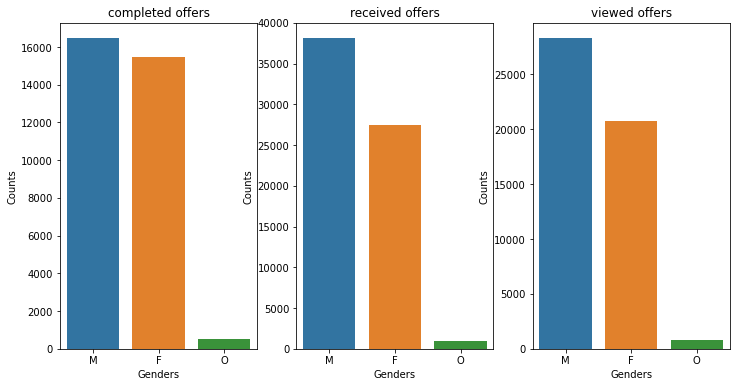

In [17]:
fig, ax = plt.subplots(
    1, 3,
    figsize = [12, 6]
)

list_offerTypes = ["completed", "received", "viewed"]
for i in range(len(list_offerTypes)):
    plot_sums(
        df_final[df_final[f"offer {list_offerTypes[i]}"] == 1],
        ["M", "F", "O"],
        f"{list_offerTypes[i]} offers",
        ax = ax[i],
        xlabel = "Genders"
    )

We can see a general trend where males view, receive and complete more offers than females (we don't really care abour `Other` since they are close to non-existent in the data). One interesting insight is, females have higher offer completion over received & view than those in males.

### b. By age

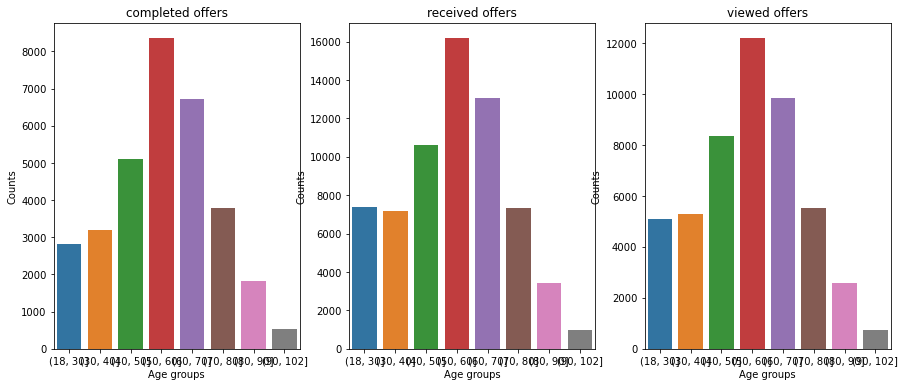

In [18]:
fig, ax = plt.subplots(
    1, 3,
    figsize = [15, 6]
)

list_offerTypes = ["completed", "received", "viewed"]
for i in range(len(list_offerTypes)):
    plot_sums(
        df_final[df_final[f"offer {list_offerTypes[i]}"] == 1],
        ['(18, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 102]'],
        f"{list_offerTypes[i]} offers",
        ax = ax[i],
        xlabel = "Age groups"
    )

Although different scales, we can see a very similar distribution patterns between age groups - a Gaussian-like distribution with 50-60 age group taking dominance.

(like honestly, this data was taken in Japan or something? I'm sitting at Starbucks right now and a lot of elder people around me, just a normal day in Japan amidst the aging population)

### c. By offer type (BOGO, Discount, Informational)

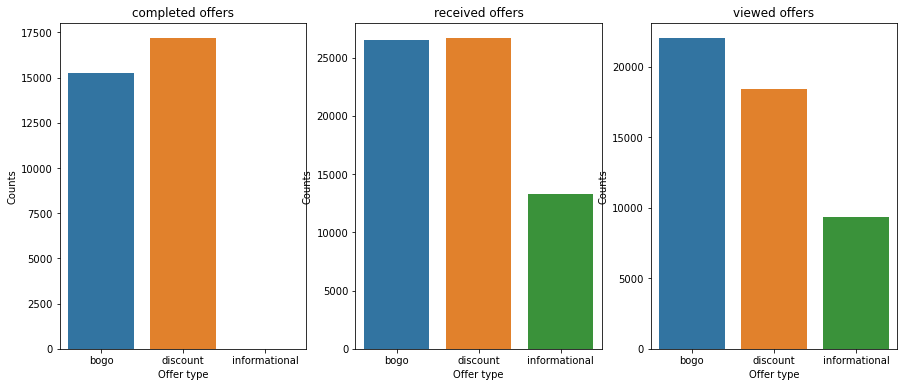

In [19]:
fig, ax = plt.subplots(
    1, 3,
    figsize = [15, 6]
)

list_offerTypes = ["completed", "received", "viewed"]
for i in range(len(list_offerTypes)):
    plot_sums(
        df_final[df_final[f"offer {list_offerTypes[i]}"] == 1],
        ['bogo', 'discount', 'informational'],
        f"{list_offerTypes[i]} offers",
        ax = ax[i],
        xlabel = "Offer type"
    )

Looks like although BOGO and Discount share the same received counts, Discount offer type is more successful than BOGO, kinda understandable since people tend to buy a cup of coffe at a discounted price rather than 2 cups of coffee at the price of one, since most of the time we don't have such company to drink along.

## 2. Success rate by offer type

discount_2_for_10_in_10_days    5003
discount_3_for_7_in_7_days      4886
bogo_5_for_5_in_7_days          4188
bogo_5_for_5_in_5_days          4103
discount_2_for_10_in_7_days     3911
bogo_10_for_10_in_7_days        3657
discount_5_for_20_in_10_days    3386
bogo_10_for_10_in_5_days        3310
Name: offer_details, dtype: int64


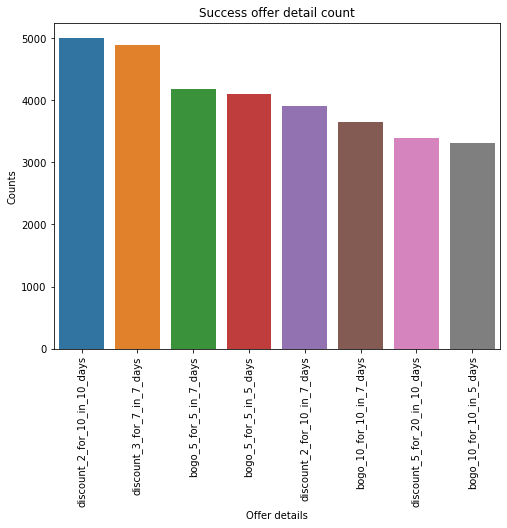

In [20]:
df_success = df_final[df_final["offer completed"] == 1]

successOffer_count = df_success["offer_details"].value_counts()
print(successOffer_count)

plt.figure(figsize = [8, 6])
sns.barplot(
    x = successOffer_count.index,
    y = successOffer_count.values
)
plt.title("Success offer detail count")
plt.xlabel("Offer details")
plt.xticks(rotation = 90)
plt.ylabel("Counts")
plt.show()

# V.Model building

Target: predicting offer success chance.

## 1. Data preparation

In [21]:
# Grab all one-hot encoded columns as data to slap into model
list_cols_onehot = []
for col in df_final.columns:
    if len(df_final[col].value_counts()) == 2:      # One-hot indeed
        list_cols_onehot.append(col)

print(list_cols_onehot)

df_model = df_final.copy()[list_cols_onehot]

print(f"Shape before drop NaNs: {df_model.shape}")
df_model = df_model.dropna()
print(f"Shape after drop NaNs: {df_model.shape}")

df_model.head()

['offer completed', 'offer received', 'offer viewed', 'F', 'M', 'O', '(18, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 102]', '(30000, 40000]', '(40000, 50000]', '(50000, 60000]', '(60000, 70000]', '(70000, 80000]', '(80000, 90000]', '(90000, 100000]', '(100000, 110000]', '(110000, 120000]', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']
Shape before drop NaNs: (148805, 29)
Shape after drop NaNs: (148805, 29)


,offer completed,offer received,offer viewed,F,M,O,"(18, 30]","(30, 40]","(40, 50]","(50, 60]",...,"(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",mobile,social,web,bogo,discount,informational
0,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0


In [28]:
# Split data into X and Y
Y = df_model["offer completed"]
print(f"Shape of Y: {Y.shape}")
X = df_model.iloc[ : , 2 : ]
print(f"Shape of X: {X.shape}")

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(f"Distribution of Y in total: {Y.value_counts()}")
print(f"Distribution of Y_train: {Y_train.value_counts()}")
print(f"Distribution of Y_test: {Y_test.value_counts()}")

Shape of Y: (148805,)
Shape of X: (148805, 27)
Distribution of Y in total: 0    116361
1     32444
Name: offer completed, dtype: int64
Distribution of Y_train: 0    93081
1    25963
Name: offer completed, dtype: int64
Distribution of Y_test: 0    23280
1     6481
Name: offer completed, dtype: int64


We can clearly see that in Y, the amount of data records of `0` is around 4 times larger than of `1`, indicating a very skewed target feature. Thus, we 

## 2. Model definitions

In this session, I will use a bunch of models, each has some simple hyperparameter settings, to test which model performs to which extent.

List of models:

1. Logistic Regression
- Customization Parameter: C (Regularization parameter)

2. Decision Trees
- Customization Parameters: max_depth, min_samples_split

3. Random Forest
- Customization Parameters: n_estimators, max_depth, min_samples_split

4. Gradient Boosting
- Customization Parameters: n_estimators, max_depth

5. K-Nearest Neighbors (KNN)
- Customization Parameter: n_neighbors

6. Naive Bayes
- No additional customization parameters

7. Neural Networks
- Customization Parameters: hidden_layer_sizes, activation, solver

In [23]:
# Fit, train & evaluate
def train_and_evaluate(
    model, 
    X_train, y_train, 
    X_test, y_test
):
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return [accuracy, precision, recall, f1]

In [30]:
# List of rudimentarily defined models
list_models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier()
]

## 3. Train & Results

In [31]:
list_model_names = [
    "Logistic Regression",
    "Decision Trees",
    "Random Forest",
    "Gradient Boosting",
    "K-Nearest Neighbors (KNN)",
    "Naive Bayes",
    "Neural Networks"
]

# To store model result metrics
df_results = pd.DataFrame(columns = [
    "model", 
    "accuracy", 
    "precision", 
    "recall", 
    "f1"
])

for i in range(len(list_models)):

    # Begin the training & evaluate
    print(f"Training #{i+1} : {list_model_names[i]}")
    this_model_name = list_model_names[i]
    this_model_results = train_and_evaluate(
        list_models[i],
        X_train = X_train,
        y_train = Y_train,
        X_test = X_test,
        y_test = Y_test
    )
    df_results.loc[len(df_results)] = [this_model_name] + this_model_results
    print(f"Finished training #{i+1} : {list_model_names[i]}")
    print(f"Results: {this_model_results}")


Training #1 : Logistic Regression


/Users/tranhuunhathuy/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Finished training #1 : Logistic Regression
Results: [0.782030173717281, 0.4, 0.001851566116340071, 0.003686069728152358]
Training #2 : Decision Trees
Finished training #2 : Decision Trees
Results: [0.7785692685057626, 0.1696969696969697, 0.004320320938126832, 0.00842612097502257]
Training #3 : Random Forest
Finished training #3 : Random Forest
Results: [0.7774268337757467, 0.22178988326848248, 0.008794939052615337, 0.016918967052537846]
Training #4 : Gradient Boosting


/Users/tranhuunhathuy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished training #4 : Gradient Boosting
Results: [0.7822317798461074, 0.0, 0.0, 0.0]
Training #5 : K-Nearest Neighbors (KNN)
Finished training #5 : K-Nearest Neighbors (KNN)
Results: [0.7447666409058835, 0.39193642178716803, 0.311988890603302, 0.3474226804123711]
Training #6 : Naive Bayes
Finished training #6 : Naive Bayes
Results: [0.6442323846644938, 0.37969418243599506, 1.0, 0.5504033970276009]
Training #7 : Neural Networks
Finished training #7 : Neural Networks
Results: [0.7819629716743389, 0.3181818181818182, 0.001080080234531708, 0.002152852529601722]


In [32]:
df_results.head(20)

,model,accuracy,precision,recall,f1
0,Logistic Regression,0.782030,0.400000,0.001852,0.003686
1,Decision Trees,0.778569,0.169697,0.004320,0.008426
2,Random Forest,0.777427,0.221790,0.008795,0.016919
3,Gradient Boosting,0.782232,0.000000,0.000000,0.000000
4,K-Nearest Neighbors (KNN),0.744767,0.391936,0.311989,0.347423
5,Naive Bayes,0.644232,0.379694,1.000000,0.550403
6,Neural Networks,0.781963,0.318182,0.001080,0.002153


## 4. Discussions

### a. Overview

- The models seem to have challenges in effectively identifying positive instances (low recall), which may be influenced by the significant class imbalance.
- Naive Bayes shows high recall but sacrifices precision, possibly due to the imbalance in class distribution.
- The F1 Score provides a balanced measure, highlighting the trade-off between precision and recall.

### b. In much greater details

1. Logistic Regression
    - Metrics
        + Accuracy: 78.20%
        + Precision: 40.00%
        + Recall: 0.19%
        + F1 Score: 0.37%
    - Analysis
        + The model has relatively high accuracy but low precision and recall.
        + The precision indicates that when the model predicts the positive class, it is correct 40% of the time. 
        + However, the recall is very low, suggesting that the model misses a significant number of positive instances.

2. Decision Trees
    - Metrics
        + Accuracy: 77.86%
        + Precision: 16.97%
        + Recall: 0.43%
        + F1 Score: 0.84%
    - Analysis
        + Similar to Logistic Regression, the Decision Trees model has low precision and recall.
        + It seems to struggle in identifying positive instances, as reflected by the low recall.

3. Random Forest
    - Metrics
        + Accuracy: 77.74%
        + Precision: 22.18%
        + Recall: 0.88%
        + F1 Score: 1.69%
    - Analysis
        + The Random Forest model shows improvement over Decision Trees in terms of precision and recall.
        + However, the recall is still quite low, indicating that there's room for improvement in capturing positive instances.

4. Gradient Boosting
    - Metrics
        + Accuracy: 78.22%
        + Precision: 0.00%
        + Recall: 0.00%
        + F1 Score: 0.00%
    - Analysis
        + The model appears to have issues with both precision and recall, resulting in an F1 Score of 0.
        + This suggests that the model struggles to correctly classify positive instances.

5. K-Nearest Neighbors (KNN)
    - Metrics
        + Accuracy: 74.48%
        + Precision: 39.19%
        + Recall: 31.20%
        + F1 Score: 34.74%
    - Analysis
        + KNN shows a decent balance between precision and recall.
        + The F1 Score suggests a more balanced performance compared to the earlier models, though there is still room for improvement.

6. Naive Bayes
    - Metrics
        + Accuracy: 64.42%
        + Precision: 37.97%
        + Recall: 100.00%
        + F1 Score: 55.04%
    - Analysis
        + Naive Bayes has high recall, but this comes at the cost of precision, as reflected in the F1 Score.
        + The model seems to be biased toward identifying positive instances, possibly due to the class imbalance.

7. Neural Networks
    - Metrics
        + Accuracy: 78.20%
        + Precision: 31.82%
        + Recall: 0.11%
        + F1 Score: 0.22%
    - Analysis
        + The Neural Networks model has high accuracy but, similar to Logistic Regression and Decision Trees, struggles with both precision and recall.

### c. Select a model to move forward

As I found out above that negative records significantly outnumber positive records with a 4:1 ratio which is extremely imbalance, it is crucial to consider the balance between precision and recall. Precision and recall are often in tension with each other - increasing one typically leads to a decrease in the other (precision-recall trade-off). Achieving a balance between precision and recall is important to ensure that the model is making predictions that are both accurate (high precision) and comprehensive (high recall).

Thus, out of 7 models with very rudimentary hyperparam settings, I decided to choose KNN, with most balanced precision-recall, high accuracy, and an acceptable F1 score.

# VI. "Can we get much higher?"

In this session, I aim to further improve the KNN model with better hyperparameters.

In [35]:
knn = KNeighborsClassifier()

param_grid = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform"],
    "metric": ["euclidean"]
}

# GridSearchCV hyperparam tuning
grid_search = GridSearchCV(
    knn, param_grid, 
    cv = 5, scoring = "f1")  # F1 Score for precision-recall balancing
grid_search.fit(X_train, Y_train)

# Best hyperparams
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Slap best params into KNN
best_knn_model = KNeighborsClassifier(
    n_neighbors = best_params["n_neighbors"],
    weights = best_params["weights"],
    metric = best_params["metric"]
)

# Fit
best_knn_model.fit(X_train, Y_train)

# Predict
Y_pred = best_knn_model.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     23280
           1       0.39      0.35      0.37      6481

    accuracy                           0.74     29761
   macro avg       0.61      0.60      0.60     29761
weighted avg       0.73      0.74      0.73     29761



# VII. Conclusions

In summary, the analysis suggests that while some models have high accuracy, there is room for improvement in identifying positive instances, especially in the context of imbalanced datasets. Consideration of precision, recall, and F1 Score provides insights into the trade-offs made by each model.

Of course, there are still rooms for improvements:
- Addressing the class imbalance and potentially adjusting the decision threshold may improve the models' performance.
- Further hyperparameter tuning and feature engineering could be explored to enhance model effectiveness.
- Evaluation using precision-recall curves and AUC-PR can provide a more detailed understanding of model performance across different decision thresholds.

Also, during data cleaning and exploring for the model, I have found several key insights:
- Regarding coffee consumption, people in the middle ages like 50 to 60 drink most coffee compared to other age groups, indicating a high level of cofee consumption around this age.
- Income shows a lot of people with low or average income going to Starbucks. People with higher incomes, especially those six-figure guys seem to not really enjoying Starbucks coffee compared to the lower income groups.
- Regarding offer reception, we can see a general trend where males view, receive and complete more offers than females and others. On the other hand, females have higher ratio of offer completion over received & view than those in males.
- Although BOGO and Discount share the same received counts, Discount offer type is more successful than BOGO, with the most prominent two being Discount type.

# VIII. Acknowledgement

- Data Source: Starbucks.
- This wonderful course where I could learn, sharpen and showcase my data skills: Udacity.